분류 실습 - 캐글 산탄데르 고객 만족 예측
고객 만족 여부를 XGBoost와 LightGBM을 활용
클레스 레이블 명 TARGET 이 값이 1이면 불만, 0이면 만족
평가 ROC-AUC로 평가

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv("train_santander.csv", encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [3]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [6]:
#불만족 비율
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [7]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [8]:
cust_df['var3'].replace(-999999, 2, inplace = True)
cust_df.drop('ID', axis = 1, inplace = True)

# 피처 세트와 레이블 세트 분리, 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size = 0.2, random_state = 0)

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape, X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts() / train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
 학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [11]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정.
xgb_clf = XGBClassifier(n_estimators = 500, random_state = 156)

#성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행.
xgb_clf.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric="auc", eval_set = [(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.799928	validation_1-auc:0.803548
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.802222	validation_1-auc:0.805222
[2]	validation_0-auc:0.80819	validation_1-auc:0.813162
[3]	validation_0-auc:0.8127	validation_1-auc:0.813243
[4]	validation_0-auc:0.81648	validation_1-auc:0.816979
[5]	validation_0-auc:0.816018	validation_1-auc:0.816629
[6]	validation_0-auc:0.816474	validation_1-auc:0.817776
[7]	validation_0-auc:0.818148	validation_1-auc:0.818464
[8]	validation_0-auc:0.81806	validation_1-auc:0.818295
[9]	validation_0-auc:0.817039	validation_1-auc:0.818087
[10]	validation_0-auc:0.818318	validation_1-auc:0.818749
[11]	validation_0-auc:0.818711	validation_1-auc:0.818521
[12]	validation_0-auc:0.818673	validation_1-auc:0.818516
[13]	validation_0-auc:0.819156	validation_1-auc:0.818998
[14]	validation_0-auc:0.819847	validation_1-auc:0.81999
[15

[142]	validation_0-auc:0.861553	validation_1-auc:0.841335
[143]	validation_0-auc:0.861682	validation_1-auc:0.841346
[144]	validation_0-auc:0.86169	validation_1-auc:0.841403
[145]	validation_0-auc:0.861852	validation_1-auc:0.841299
[146]	validation_0-auc:0.861898	validation_1-auc:0.841301
[147]	validation_0-auc:0.861998	validation_1-auc:0.841289
[148]	validation_0-auc:0.862068	validation_1-auc:0.84135
[149]	validation_0-auc:0.862132	validation_1-auc:0.841444
[150]	validation_0-auc:0.862236	validation_1-auc:0.841409
[151]	validation_0-auc:0.862314	validation_1-auc:0.841459
[152]	validation_0-auc:0.862584	validation_1-auc:0.841456
[153]	validation_0-auc:0.862843	validation_1-auc:0.841483
[154]	validation_0-auc:0.863033	validation_1-auc:0.841493
[155]	validation_0-auc:0.863132	validation_1-auc:0.841534
[156]	validation_0-auc:0.863423	validation_1-auc:0.841728
[157]	validation_0-auc:0.863578	validation_1-auc:0.841712
[158]	validation_0-auc:0.863872	validation_1-auc:0.841677
[159]	validation

In [14]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators = 100)

params = {'max_depth': [5, 7], 'min_child_weight':[1, 3], 'colsample_bytree':[0.5, 0.75] }

# cv는 3으로 지정
gridcv = GridSearchCV(xgb_clf, param_grid = params, cv = 3)
gridcv.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric = "auc", eval_set = [(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average = 'macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.715421	validation_1-auc:0.722463
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.802772	validation_1-auc:0.807648
[2]	validation_0-auc:0.800147	validation_1-auc:0.804566
[3]	validation_0-auc:0.805692	validation_1-auc:0.809325
[4]	validation_0-auc:0.814807	validation_1-auc:0.816951
[5]	validation_0-auc:0.810346	validation_1-auc:0.812634
[6]	validation_0-auc:0.810623	validation_1-auc:0.814491
[7]	validation_0-auc:0.818556	validation_1-auc:0.820561
[8]	validation_0-auc:0.822006	validation_1-auc:0.823553
[9]	validation_0-auc:0.820433	validation_1-auc:0.821292
[10]	validation_0-auc:0.826212	validation_1-auc:0.825279
[11]	validation_0-auc:0.830077	validation_1-auc:0.827817
[12]	validation_0-auc:0.832328	validation_1-auc:0.828775
[13]	validation_0-auc:0.832008	validation_1-auc:0.827865
[14]	validation_0-auc:0.830319	validation_1-auc:0.82674

[51]	validation_0-auc:0.86387	validation_1-auc:0.843007
[52]	validation_0-auc:0.864428	validation_1-auc:0.843608
[53]	validation_0-auc:0.86492	validation_1-auc:0.843887
[54]	validation_0-auc:0.865341	validation_1-auc:0.844128
[55]	validation_0-auc:0.865713	validation_1-auc:0.843955
[56]	validation_0-auc:0.866165	validation_1-auc:0.844301
[57]	validation_0-auc:0.866538	validation_1-auc:0.84439
[58]	validation_0-auc:0.86671	validation_1-auc:0.844055
[59]	validation_0-auc:0.866977	validation_1-auc:0.843974
[60]	validation_0-auc:0.867483	validation_1-auc:0.8439
[61]	validation_0-auc:0.867853	validation_1-auc:0.843561
[62]	validation_0-auc:0.86811	validation_1-auc:0.843594
[63]	validation_0-auc:0.868319	validation_1-auc:0.843498
[64]	validation_0-auc:0.868554	validation_1-auc:0.843615
[65]	validation_0-auc:0.869021	validation_1-auc:0.843756
[66]	validation_0-auc:0.869095	validation_1-auc:0.843781
[67]	validation_0-auc:0.869277	validation_1-auc:0.843635
[68]	validation_0-auc:0.869639	validat

[1]	validation_0-auc:0.804027	validation_1-auc:0.809028
[2]	validation_0-auc:0.796929	validation_1-auc:0.805684
[3]	validation_0-auc:0.80379	validation_1-auc:0.811591
[4]	validation_0-auc:0.811904	validation_1-auc:0.818375
[5]	validation_0-auc:0.808826	validation_1-auc:0.815714
[6]	validation_0-auc:0.809236	validation_1-auc:0.816054
[7]	validation_0-auc:0.818354	validation_1-auc:0.823376
[8]	validation_0-auc:0.822085	validation_1-auc:0.826164
[9]	validation_0-auc:0.82165	validation_1-auc:0.824633
[10]	validation_0-auc:0.825876	validation_1-auc:0.828152
[11]	validation_0-auc:0.830307	validation_1-auc:0.830536
[12]	validation_0-auc:0.832494	validation_1-auc:0.831414
[13]	validation_0-auc:0.832283	validation_1-auc:0.831058
[14]	validation_0-auc:0.830152	validation_1-auc:0.829388
[15]	validation_0-auc:0.833723	validation_1-auc:0.831545
[16]	validation_0-auc:0.835902	validation_1-auc:0.833087
[17]	validation_0-auc:0.838024	validation_1-auc:0.835309
[18]	validation_0-auc:0.840344	validation_

[57]	validation_0-auc:0.863066	validation_1-auc:0.845717
[58]	validation_0-auc:0.863413	validation_1-auc:0.845678
[59]	validation_0-auc:0.863608	validation_1-auc:0.84581
[60]	validation_0-auc:0.86412	validation_1-auc:0.845891
[61]	validation_0-auc:0.864399	validation_1-auc:0.845775
[62]	validation_0-auc:0.864521	validation_1-auc:0.845851
[63]	validation_0-auc:0.864786	validation_1-auc:0.845721
[64]	validation_0-auc:0.865062	validation_1-auc:0.845821
[65]	validation_0-auc:0.865567	validation_1-auc:0.845831
[66]	validation_0-auc:0.865616	validation_1-auc:0.845926
[67]	validation_0-auc:0.865942	validation_1-auc:0.845591
[68]	validation_0-auc:0.866071	validation_1-auc:0.845562
[69]	validation_0-auc:0.866158	validation_1-auc:0.845375
[70]	validation_0-auc:0.866421	validation_1-auc:0.845291
[71]	validation_0-auc:0.866631	validation_1-auc:0.845063
[72]	validation_0-auc:0.866834	validation_1-auc:0.844927
[73]	validation_0-auc:0.867035	validation_1-auc:0.844978
[74]	validation_0-auc:0.867128	va

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.809965	validation_1-auc:0.808886
[2]	validation_0-auc:0.804423	validation_1-auc:0.807373
[3]	validation_0-auc:0.815189	validation_1-auc:0.816603
[4]	validation_0-auc:0.824234	validation_1-auc:0.823278
[5]	validation_0-auc:0.819568	validation_1-auc:0.81934
[6]	validation_0-auc:0.819199	validation_1-auc:0.818772
[7]	validation_0-auc:0.827364	validation_1-auc:0.826183
[8]	validation_0-auc:0.831947	validation_1-auc:0.829293
[9]	validation_0-auc:0.832248	validation_1-auc:0.827116
[10]	validation_0-auc:0.836511	validation_1-auc:0.829685
[11]	validation_0-auc:0.841032	validation_1-auc:0.831312
[12]	validation_0-auc:0.843673	validation_1-auc:0.831989
[13]	validation_0-auc:0.843697	validation_1-auc:0.832132
[14]	validation_0-auc:0.843356	validation_1-auc:0.830392
[15]	validation_0-auc:0.846759	validation_1-auc:0.83237

[77]	validation_0-auc:0.892957	validation_1-auc:0.844356
[78]	validation_0-auc:0.893228	validation_1-auc:0.84433
[79]	validation_0-auc:0.893375	validation_1-auc:0.844108
[80]	validation_0-auc:0.893476	validation_1-auc:0.844037
[81]	validation_0-auc:0.893656	validation_1-auc:0.844067
[82]	validation_0-auc:0.893838	validation_1-auc:0.843845
[83]	validation_0-auc:0.894993	validation_1-auc:0.84388
[84]	validation_0-auc:0.895174	validation_1-auc:0.843781
[85]	validation_0-auc:0.895171	validation_1-auc:0.844018
[86]	validation_0-auc:0.895293	validation_1-auc:0.843721
[87]	validation_0-auc:0.895377	validation_1-auc:0.843689
[88]	validation_0-auc:0.895614	validation_1-auc:0.8435
[89]	validation_0-auc:0.895597	validation_1-auc:0.84341
[90]	validation_0-auc:0.896023	validation_1-auc:0.843738
[91]	validation_0-auc:0.896194	validation_1-auc:0.843675
[92]	validation_0-auc:0.896304	validation_1-auc:0.843666
[93]	validation_0-auc:0.896388	validation_1-auc:0.8436
[94]	validation_0-auc:0.89645	validati

[17]	validation_0-auc:0.85058	validation_1-auc:0.835537
[18]	validation_0-auc:0.852488	validation_1-auc:0.836913
[19]	validation_0-auc:0.851413	validation_1-auc:0.83678
[20]	validation_0-auc:0.853824	validation_1-auc:0.837786
[21]	validation_0-auc:0.853711	validation_1-auc:0.836986
[22]	validation_0-auc:0.852989	validation_1-auc:0.835059
[23]	validation_0-auc:0.855112	validation_1-auc:0.836803
[24]	validation_0-auc:0.856859	validation_1-auc:0.838802
[25]	validation_0-auc:0.85723	validation_1-auc:0.83782
[26]	validation_0-auc:0.857535	validation_1-auc:0.836375
[27]	validation_0-auc:0.85929	validation_1-auc:0.837784
[28]	validation_0-auc:0.860972	validation_1-auc:0.837979
[29]	validation_0-auc:0.860682	validation_1-auc:0.837827
[30]	validation_0-auc:0.862143	validation_1-auc:0.838806
[31]	validation_0-auc:0.863184	validation_1-auc:0.839024
[32]	validation_0-auc:0.863638	validation_1-auc:0.838132
[33]	validation_0-auc:0.864268	validation_1-auc:0.838288
[34]	validation_0-auc:0.8644	validat

Stopping. Best iteration:
[65]	validation_0-auc:0.882333	validation_1-auc:0.843298

[0]	validation_0-auc:0.740963	validation_1-auc:0.745305
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.82294	validation_1-auc:0.821542
[2]	validation_0-auc:0.813813	validation_1-auc:0.809933
[3]	validation_0-auc:0.827473	validation_1-auc:0.822227
[4]	validation_0-auc:0.832393	validation_1-auc:0.826685
[5]	validation_0-auc:0.831888	validation_1-auc:0.822684
[6]	validation_0-auc:0.831945	validation_1-auc:0.821011
[7]	validation_0-auc:0.835043	validation_1-auc:0.824823
[8]	validation_0-auc:0.839917	validation_1-auc:0.82833
[9]	validation_0-auc:0.839675	validation_1-auc:0.827635
[10]	validation_0-auc:0.843606	validation_1-auc:0.829718
[11]	validation_0-auc:0.846078	validation_1-auc:0.833888
[12]	validation_0-auc:0.848075	validation_1-auc:0.834836
[13]	validation_0-auc:0.849433

[45]	validation_0-auc:0.860625	validation_1-auc:0.839082
[46]	validation_0-auc:0.860953	validation_1-auc:0.839125
[47]	validation_0-auc:0.861608	validation_1-auc:0.838995
[48]	validation_0-auc:0.862085	validation_1-auc:0.839059
[49]	validation_0-auc:0.862354	validation_1-auc:0.839387
[50]	validation_0-auc:0.862812	validation_1-auc:0.839298
[51]	validation_0-auc:0.863372	validation_1-auc:0.839127
[52]	validation_0-auc:0.864029	validation_1-auc:0.839097
[53]	validation_0-auc:0.864379	validation_1-auc:0.839118
[54]	validation_0-auc:0.864775	validation_1-auc:0.838848
[55]	validation_0-auc:0.86518	validation_1-auc:0.838897
[56]	validation_0-auc:0.865428	validation_1-auc:0.838671
[57]	validation_0-auc:0.865679	validation_1-auc:0.838451
[58]	validation_0-auc:0.866057	validation_1-auc:0.838382
[59]	validation_0-auc:0.866205	validation_1-auc:0.838363
[60]	validation_0-auc:0.866485	validation_1-auc:0.83804
[61]	validation_0-auc:0.866681	validation_1-auc:0.837604
[62]	validation_0-auc:0.867	valid

[17]	validation_0-auc:0.844972	validation_1-auc:0.836283
[18]	validation_0-auc:0.845411	validation_1-auc:0.836243
[19]	validation_0-auc:0.845623	validation_1-auc:0.837443
[20]	validation_0-auc:0.846563	validation_1-auc:0.837309
[21]	validation_0-auc:0.846794	validation_1-auc:0.837453
[22]	validation_0-auc:0.847843	validation_1-auc:0.837781
[23]	validation_0-auc:0.848615	validation_1-auc:0.838383
[24]	validation_0-auc:0.849434	validation_1-auc:0.838103
[25]	validation_0-auc:0.85036	validation_1-auc:0.838932
[26]	validation_0-auc:0.850801	validation_1-auc:0.838703
[27]	validation_0-auc:0.850936	validation_1-auc:0.837935
[28]	validation_0-auc:0.851557	validation_1-auc:0.837842
[29]	validation_0-auc:0.852139	validation_1-auc:0.837859
[30]	validation_0-auc:0.852693	validation_1-auc:0.8387
[31]	validation_0-auc:0.853579	validation_1-auc:0.838874
[32]	validation_0-auc:0.853998	validation_1-auc:0.838908
[33]	validation_0-auc:0.85455	validation_1-auc:0.839699
[34]	validation_0-auc:0.855415	vali

[59]	validation_0-auc:0.862575	validation_1-auc:0.839266
[60]	validation_0-auc:0.862755	validation_1-auc:0.839195
[61]	validation_0-auc:0.86307	validation_1-auc:0.839449
[62]	validation_0-auc:0.863241	validation_1-auc:0.839404
[63]	validation_0-auc:0.863658	validation_1-auc:0.839428
[64]	validation_0-auc:0.86375	validation_1-auc:0.839621
[65]	validation_0-auc:0.86421	validation_1-auc:0.839633
[66]	validation_0-auc:0.86447	validation_1-auc:0.839787
[67]	validation_0-auc:0.86483	validation_1-auc:0.839489
[68]	validation_0-auc:0.864976	validation_1-auc:0.839477
[69]	validation_0-auc:0.865145	validation_1-auc:0.83945
Stopping. Best iteration:
[39]	validation_0-auc:0.855169	validation_1-auc:0.840194

[0]	validation_0-auc:0.811089	validation_1-auc:0.810522
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.816087	validation_1-auc:0.810073
[2]	validation_0-auc:0.822

[27]	validation_0-auc:0.85049	validation_1-auc:0.838129
[28]	validation_0-auc:0.850674	validation_1-auc:0.837812
[29]	validation_0-auc:0.851227	validation_1-auc:0.838234
[30]	validation_0-auc:0.851623	validation_1-auc:0.838185
[31]	validation_0-auc:0.852504	validation_1-auc:0.838433
[32]	validation_0-auc:0.853015	validation_1-auc:0.838103
[33]	validation_0-auc:0.8536	validation_1-auc:0.838398
[34]	validation_0-auc:0.854335	validation_1-auc:0.838896
[35]	validation_0-auc:0.854663	validation_1-auc:0.839009
[36]	validation_0-auc:0.855138	validation_1-auc:0.839035
[37]	validation_0-auc:0.855351	validation_1-auc:0.839193
[38]	validation_0-auc:0.856105	validation_1-auc:0.839668
[39]	validation_0-auc:0.856527	validation_1-auc:0.83972
[40]	validation_0-auc:0.857019	validation_1-auc:0.840403
[41]	validation_0-auc:0.8577	validation_1-auc:0.840506
[42]	validation_0-auc:0.85823	validation_1-auc:0.840863
[43]	validation_0-auc:0.858341	validation_1-auc:0.840702
[44]	validation_0-auc:0.858849	validat

[4]	validation_0-auc:0.83547	validation_1-auc:0.826685
[5]	validation_0-auc:0.840865	validation_1-auc:0.832065
[6]	validation_0-auc:0.843256	validation_1-auc:0.831047
[7]	validation_0-auc:0.844488	validation_1-auc:0.82997
[8]	validation_0-auc:0.846035	validation_1-auc:0.83064
[9]	validation_0-auc:0.847946	validation_1-auc:0.831142
[10]	validation_0-auc:0.848745	validation_1-auc:0.831627
[11]	validation_0-auc:0.850347	validation_1-auc:0.832598
[12]	validation_0-auc:0.851272	validation_1-auc:0.832519
[13]	validation_0-auc:0.853669	validation_1-auc:0.834865
[14]	validation_0-auc:0.855251	validation_1-auc:0.835849
[15]	validation_0-auc:0.856435	validation_1-auc:0.83605
[16]	validation_0-auc:0.857587	validation_1-auc:0.836177
[17]	validation_0-auc:0.859351	validation_1-auc:0.836231
[18]	validation_0-auc:0.860285	validation_1-auc:0.836331
[19]	validation_0-auc:0.860357	validation_1-auc:0.837599
[20]	validation_0-auc:0.862392	validation_1-auc:0.83764
[21]	validation_0-auc:0.862808	validation_

[63]	validation_0-auc:0.89141	validation_1-auc:0.841085
[64]	validation_0-auc:0.891682	validation_1-auc:0.841143
[65]	validation_0-auc:0.892278	validation_1-auc:0.841065
[66]	validation_0-auc:0.892727	validation_1-auc:0.840958
[67]	validation_0-auc:0.893137	validation_1-auc:0.840921
[68]	validation_0-auc:0.893388	validation_1-auc:0.840771
[69]	validation_0-auc:0.893529	validation_1-auc:0.84087
[70]	validation_0-auc:0.893802	validation_1-auc:0.840709
[71]	validation_0-auc:0.893855	validation_1-auc:0.840794
[72]	validation_0-auc:0.894019	validation_1-auc:0.840836
[73]	validation_0-auc:0.894373	validation_1-auc:0.841008
[74]	validation_0-auc:0.894542	validation_1-auc:0.840932
[75]	validation_0-auc:0.894724	validation_1-auc:0.840937
Stopping. Best iteration:
[45]	validation_0-auc:0.884335	validation_1-auc:0.842062

[0]	validation_0-auc:0.816109	validation_1-auc:0.811
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-a

[59]	validation_0-auc:0.882357	validation_1-auc:0.841579
[60]	validation_0-auc:0.882716	validation_1-auc:0.841512
[61]	validation_0-auc:0.882939	validation_1-auc:0.841415
[62]	validation_0-auc:0.883049	validation_1-auc:0.841426
[63]	validation_0-auc:0.883365	validation_1-auc:0.841612
[64]	validation_0-auc:0.883681	validation_1-auc:0.841852
[65]	validation_0-auc:0.884057	validation_1-auc:0.841847
[66]	validation_0-auc:0.884053	validation_1-auc:0.841909
[67]	validation_0-auc:0.88446	validation_1-auc:0.841985
[68]	validation_0-auc:0.884938	validation_1-auc:0.841768
[69]	validation_0-auc:0.885009	validation_1-auc:0.841656
[70]	validation_0-auc:0.885288	validation_1-auc:0.841626
[71]	validation_0-auc:0.885498	validation_1-auc:0.841288
[72]	validation_0-auc:0.885587	validation_1-auc:0.841334
[73]	validation_0-auc:0.885921	validation_1-auc:0.841217
[74]	validation_0-auc:0.886022	validation_1-auc:0.841253
[75]	validation_0-auc:0.886104	validation_1-auc:0.841179
[76]	validation_0-auc:0.886118	v

[19]	validation_0-auc:0.846482	validation_1-auc:0.838554
[20]	validation_0-auc:0.848726	validation_1-auc:0.840214
[21]	validation_0-auc:0.847695	validation_1-auc:0.838583
[22]	validation_0-auc:0.84676	validation_1-auc:0.838167
[23]	validation_0-auc:0.848966	validation_1-auc:0.83963
[24]	validation_0-auc:0.850153	validation_1-auc:0.840161
[25]	validation_0-auc:0.850518	validation_1-auc:0.838865
[26]	validation_0-auc:0.850326	validation_1-auc:0.83861
[27]	validation_0-auc:0.851898	validation_1-auc:0.839714
[28]	validation_0-auc:0.853439	validation_1-auc:0.83974
[29]	validation_0-auc:0.853446	validation_1-auc:0.840649
[30]	validation_0-auc:0.854315	validation_1-auc:0.840818
[31]	validation_0-auc:0.855389	validation_1-auc:0.841412
[32]	validation_0-auc:0.855959	validation_1-auc:0.841502
[33]	validation_0-auc:0.856346	validation_1-auc:0.841478
[34]	validation_0-auc:0.856286	validation_1-auc:0.841234
[35]	validation_0-auc:0.857969	validation_1-auc:0.842276
[36]	validation_0-auc:0.859291	vali

In [17]:
#n_estimators는 1000으로 증가시키고, learning_rate = 0.02로 감소, reg_alpha = 0.03으로 추가함.
xgb_clf =XGBClassifier(n_estimators = 1000, random_state = 156, learning_rate = 0.02, max_depth = 7, min_child_weight = 1, colsample_bytree = 0.75, reg_alph = 0.03)

# 성능 평가 지표를 auc로, 조기 중단 파라미터 값은 200으로 설정하고 학습 수행
xgb_clf.fit(X_train, y_train, early_stopping_rounds = 200, eval_metric= "auc", eval_set = [(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC : {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82311	validation_1-auc:0.815222
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.827356	validation_1-auc:0.816566
[2]	validation_0-auc:0.832181	validation_1-auc:0.820398
[3]	validation_0-auc:0.836032	validation_1-auc:0.825197
[4]	validation_0-auc:0.838394	validation_1-auc:0.826233
[5]	validation_0-auc:0.838015	validation_1-auc:0.827382
[6]	validation_0-auc:0.838176	validation_1-auc:0.826939
[7]	validation_0-auc:0.838419	validation_1-auc:0.82705
[8]	validation_0-auc:0.839415	validation_1-auc:0.827883
[9]	validation_0-auc:0.839734	validation_1-auc:0.827747
[10]	validation_0-auc:0.841486	validation_1-auc:0.828895
[11]	validation_0-auc:0.840855	validation_1-auc:0.827977
[12]	validation_0-auc:0.84115	validation_1-auc:0.828366
[13]	validation_0-auc:0.841462	validation_1-auc:0.828181
[14]	validation_0-auc:0.845212	validation_1-auc:0.834013


[142]	validation_0-auc:0.879003	validation_1-auc:0.843634
[143]	validation_0-auc:0.879084	validation_1-auc:0.843582
[144]	validation_0-auc:0.879247	validation_1-auc:0.843775
[145]	validation_0-auc:0.879589	validation_1-auc:0.843733
[146]	validation_0-auc:0.879798	validation_1-auc:0.843799
[147]	validation_0-auc:0.879881	validation_1-auc:0.84393
[148]	validation_0-auc:0.87986	validation_1-auc:0.843929
[149]	validation_0-auc:0.880009	validation_1-auc:0.843791
[150]	validation_0-auc:0.880169	validation_1-auc:0.843891
[151]	validation_0-auc:0.880165	validation_1-auc:0.843805
[152]	validation_0-auc:0.88019	validation_1-auc:0.843901
[153]	validation_0-auc:0.880102	validation_1-auc:0.843759
[154]	validation_0-auc:0.880571	validation_1-auc:0.843848
[155]	validation_0-auc:0.88066	validation_1-auc:0.843756
[156]	validation_0-auc:0.88105	validation_1-auc:0.843723
[157]	validation_0-auc:0.881372	validation_1-auc:0.843732
[158]	validation_0-auc:0.881892	validation_1-auc:0.843948
[159]	validation_0-

[284]	validation_0-auc:0.904259	validation_1-auc:0.844525
[285]	validation_0-auc:0.904341	validation_1-auc:0.844503
[286]	validation_0-auc:0.904392	validation_1-auc:0.844551
[287]	validation_0-auc:0.904539	validation_1-auc:0.844608
[288]	validation_0-auc:0.904629	validation_1-auc:0.844579
[289]	validation_0-auc:0.904764	validation_1-auc:0.844577
[290]	validation_0-auc:0.904875	validation_1-auc:0.844484
[291]	validation_0-auc:0.904896	validation_1-auc:0.844514
[292]	validation_0-auc:0.904949	validation_1-auc:0.844501
[293]	validation_0-auc:0.905049	validation_1-auc:0.844489
[294]	validation_0-auc:0.905125	validation_1-auc:0.844421
[295]	validation_0-auc:0.905198	validation_1-auc:0.844375
[296]	validation_0-auc:0.905242	validation_1-auc:0.844348
[297]	validation_0-auc:0.90535	validation_1-auc:0.844362
[298]	validation_0-auc:0.905426	validation_1-auc:0.844305
[299]	validation_0-auc:0.905481	validation_1-auc:0.844276
[300]	validation_0-auc:0.905551	validation_1-auc:0.844247
[301]	validatio

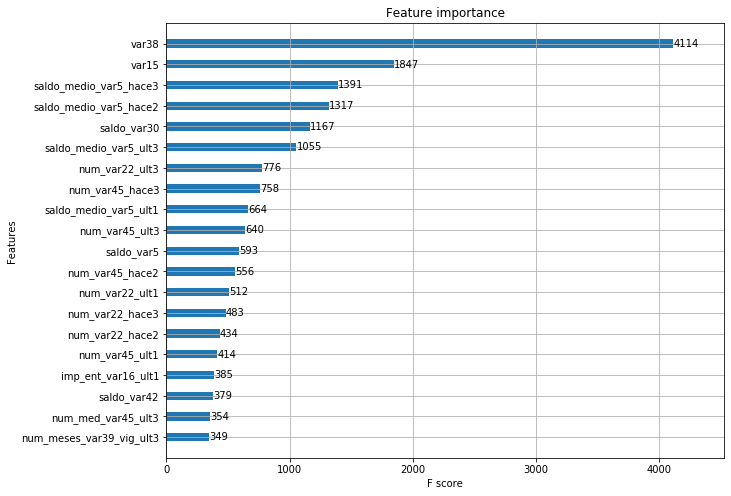

In [18]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize = (10, 8))
plot_importance(xgb_clf, ax = ax, max_num_features = 20, height = 0.4)

In [19]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators = 500)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = "auc", eval_set = evals, verbose = True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average = 'macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.817384	valid_0's binary_logloss: 0.165046
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.818903	valid_0's binary_logloss: 0.160006
[3]	valid_0's auc: 0.827707	valid_0's binary_logloss: 0.156323
[4]	valid_0's auc: 0.832155	valid_0's binary_logloss: 0.153463
[5]	valid_0's auc: 0.834677	valid_0's binary_logloss: 0.151256
[6]	valid_0's auc: 0.834093	valid_0's binary_logloss: 0.149427
[7]	valid_0's auc: 0.837046	valid_0's binary_logloss: 0.147961
[8]	valid_0's auc: 0.837838	valid_0's binary_logloss: 0.146591
[9]	valid_0's auc: 0.839435	valid_0's binary_logloss: 0.145455
[10]	valid_0's auc: 0.83973	valid_0's binary_logloss: 0.144486
[11]	valid_0's auc: 0.839799	valid_0's binary_logloss: 0.143769
[12]	valid_0's auc: 0.840034	valid_0's binary_logloss: 0.143146
[13]	valid_0's auc: 0.840271	valid_0's binary_logloss: 0.142533
[14]	valid_0's auc: 0.840342	valid_0's binary_logloss: 0.142036
[15]	valid_0's auc: 0.840928	valid_0's binary_loglos

In [23]:
from sklearn.model_selection import GridSearchCV

lgbm_clf = LGBMClassifier(n_estimators = 200)

params = {'num_leaves': [32, 64], 'max_depth':[128, 160], 'min_child_samples':[60,100], 'subsample':[0.8, 1]}

gridcv = GridSearchCV(lgbm_clf, param_grid = params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric = "auc", eval_set = [(X_train, y_train), (X_test, y_test)])
print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826533	valid_1's binary_logloss: 0.156346
[4]	valid_0's auc: 0.83865	valid_0's binary_logloss: 0.144126	valid_1's auc: 0.833166	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.842822	valid_0's binary_logloss: 0.141725	valid_1's auc: 0.836448	valid_1's binary_logloss: 0.151167
[6]	valid_0's auc: 0.844702	valid_0's binary_logloss: 0.139642	valid_1's auc: 0.837094	valid_1's binary_logloss: 0.149356
[7]	valid_0's auc: 0.847144	valid_0's binary_logloss: 0.13794	valid_1's auc: 0.837965	valid_1's binary_logloss: 0.147853
[8]	valid_0's auc: 0.848277	valid_0's binary_logloss: 0.136499	valid_1's auc: 0.837663	val

[28]	valid_0's auc: 0.872024	valid_0's binary_logloss: 0.124672	valid_1's auc: 0.838405	valid_1's binary_logloss: 0.139526
[29]	valid_0's auc: 0.873184	valid_0's binary_logloss: 0.124303	valid_1's auc: 0.838211	valid_1's binary_logloss: 0.139531
[30]	valid_0's auc: 0.874076	valid_0's binary_logloss: 0.12403	valid_1's auc: 0.838983	valid_1's binary_logloss: 0.139411
[31]	valid_0's auc: 0.874768	valid_0's binary_logloss: 0.123745	valid_1's auc: 0.839314	valid_1's binary_logloss: 0.139314
[32]	valid_0's auc: 0.875593	valid_0's binary_logloss: 0.123486	valid_1's auc: 0.838875	valid_1's binary_logloss: 0.139322
[33]	valid_0's auc: 0.8767	valid_0's binary_logloss: 0.123182	valid_1's auc: 0.838809	valid_1's binary_logloss: 0.139329
[34]	valid_0's auc: 0.87774	valid_0's binary_logloss: 0.122892	valid_1's auc: 0.838376	valid_1's binary_logloss: 0.139342
[35]	valid_0's auc: 0.878372	valid_0's binary_logloss: 0.122634	valid_1's auc: 0.838454	valid_1's binary_logloss: 0.13931
[36]	valid_0's auc: 0

[55]	valid_0's auc: 0.888289	valid_0's binary_logloss: 0.118675	valid_1's auc: 0.837878	valid_1's binary_logloss: 0.139392
[56]	valid_0's auc: 0.888615	valid_0's binary_logloss: 0.118561	valid_1's auc: 0.837776	valid_1's binary_logloss: 0.139418
[57]	valid_0's auc: 0.889157	valid_0's binary_logloss: 0.118369	valid_1's auc: 0.837585	valid_1's binary_logloss: 0.139447
[58]	valid_0's auc: 0.889659	valid_0's binary_logloss: 0.11819	valid_1's auc: 0.837789	valid_1's binary_logloss: 0.139431
Early stopping, best iteration is:
[28]	valid_0's auc: 0.87235	valid_0's binary_logloss: 0.12484	valid_1's auc: 0.840114	valid_1's binary_logloss: 0.139236
[1]	valid_0's auc: 0.820235	valid_0's binary_logloss: 0.156085	valid_1's auc: 0.81613	valid_1's binary_logloss: 0.164992
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.825778	valid_0's binary_logloss: 0.150951	valid_1's auc: 0.821835	valid_1's binary_logloss: 0.159874
[3]	valid_0's auc: 0.832262	valid_0's binary_logl

[26]	valid_0's auc: 0.870347	valid_0's binary_logloss: 0.125288	valid_1's auc: 0.838228	valid_1's binary_logloss: 0.139618
[27]	valid_0's auc: 0.871198	valid_0's binary_logloss: 0.124953	valid_1's auc: 0.838403	valid_1's binary_logloss: 0.139594
[28]	valid_0's auc: 0.872024	valid_0's binary_logloss: 0.124672	valid_1's auc: 0.838405	valid_1's binary_logloss: 0.139526
[29]	valid_0's auc: 0.873184	valid_0's binary_logloss: 0.124303	valid_1's auc: 0.838211	valid_1's binary_logloss: 0.139531
[30]	valid_0's auc: 0.874076	valid_0's binary_logloss: 0.12403	valid_1's auc: 0.838983	valid_1's binary_logloss: 0.139411
[31]	valid_0's auc: 0.874768	valid_0's binary_logloss: 0.123745	valid_1's auc: 0.839314	valid_1's binary_logloss: 0.139314
[32]	valid_0's auc: 0.875593	valid_0's binary_logloss: 0.123486	valid_1's auc: 0.838875	valid_1's binary_logloss: 0.139322
[33]	valid_0's auc: 0.8767	valid_0's binary_logloss: 0.123182	valid_1's auc: 0.838809	valid_1's binary_logloss: 0.139329
[34]	valid_0's auc:

[53]	valid_0's auc: 0.887867	valid_0's binary_logloss: 0.118974	valid_1's auc: 0.838044	valid_1's binary_logloss: 0.13936
[54]	valid_0's auc: 0.888093	valid_0's binary_logloss: 0.118834	valid_1's auc: 0.838137	valid_1's binary_logloss: 0.13935
[55]	valid_0's auc: 0.888289	valid_0's binary_logloss: 0.118675	valid_1's auc: 0.837878	valid_1's binary_logloss: 0.139392
[56]	valid_0's auc: 0.888615	valid_0's binary_logloss: 0.118561	valid_1's auc: 0.837776	valid_1's binary_logloss: 0.139418
[57]	valid_0's auc: 0.889157	valid_0's binary_logloss: 0.118369	valid_1's auc: 0.837585	valid_1's binary_logloss: 0.139447
[58]	valid_0's auc: 0.889659	valid_0's binary_logloss: 0.11819	valid_1's auc: 0.837789	valid_1's binary_logloss: 0.139431
Early stopping, best iteration is:
[28]	valid_0's auc: 0.87235	valid_0's binary_logloss: 0.12484	valid_1's auc: 0.840114	valid_1's binary_logloss: 0.139236
[1]	valid_0's auc: 0.832891	valid_0's binary_logloss: 0.155302	valid_1's auc: 0.818851	valid_1's binary_loglo

[27]	valid_0's auc: 0.889589	valid_0's binary_logloss: 0.119012	valid_1's auc: 0.836951	valid_1's binary_logloss: 0.139843
[28]	valid_0's auc: 0.890552	valid_0's binary_logloss: 0.118602	valid_1's auc: 0.836524	valid_1's binary_logloss: 0.139871
[29]	valid_0's auc: 0.891402	valid_0's binary_logloss: 0.118166	valid_1's auc: 0.836264	valid_1's binary_logloss: 0.139884
[30]	valid_0's auc: 0.891982	valid_0's binary_logloss: 0.117805	valid_1's auc: 0.835959	valid_1's binary_logloss: 0.139937
[31]	valid_0's auc: 0.893185	valid_0's binary_logloss: 0.117392	valid_1's auc: 0.836384	valid_1's binary_logloss: 0.13992
[32]	valid_0's auc: 0.894065	valid_0's binary_logloss: 0.117017	valid_1's auc: 0.836341	valid_1's binary_logloss: 0.139888
[33]	valid_0's auc: 0.894791	valid_0's binary_logloss: 0.116671	valid_1's auc: 0.836753	valid_1's binary_logloss: 0.139812
[34]	valid_0's auc: 0.895313	valid_0's binary_logloss: 0.116321	valid_1's auc: 0.836733	valid_1's binary_logloss: 0.139826
[35]	valid_0's au

[1]	valid_0's auc: 0.832891	valid_0's binary_logloss: 0.155302	valid_1's auc: 0.818851	valid_1's binary_logloss: 0.164826
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.84519	valid_0's binary_logloss: 0.149727	valid_1's auc: 0.827144	valid_1's binary_logloss: 0.159879
[3]	valid_0's auc: 0.848018	valid_0's binary_logloss: 0.145627	valid_1's auc: 0.826851	valid_1's binary_logloss: 0.15631
[4]	valid_0's auc: 0.851096	valid_0's binary_logloss: 0.142423	valid_1's auc: 0.83073	valid_1's binary_logloss: 0.1534
[5]	valid_0's auc: 0.854735	valid_0's binary_logloss: 0.139746	valid_1's auc: 0.832753	valid_1's binary_logloss: 0.151136
[6]	valid_0's auc: 0.856928	valid_0's binary_logloss: 0.137509	valid_1's auc: 0.835605	valid_1's binary_logloss: 0.14924
[7]	valid_0's auc: 0.859448	valid_0's binary_logloss: 0.135575	valid_1's auc: 0.835612	valid_1's binary_logloss: 0.147799
[8]	valid_0's auc: 0.861685	valid_0's binary_logloss: 0.133953	valid_1's auc: 0.834408	vali

[29]	valid_0's auc: 0.891402	valid_0's binary_logloss: 0.118166	valid_1's auc: 0.836264	valid_1's binary_logloss: 0.139884
[30]	valid_0's auc: 0.891982	valid_0's binary_logloss: 0.117805	valid_1's auc: 0.835959	valid_1's binary_logloss: 0.139937
[31]	valid_0's auc: 0.893185	valid_0's binary_logloss: 0.117392	valid_1's auc: 0.836384	valid_1's binary_logloss: 0.13992
[32]	valid_0's auc: 0.894065	valid_0's binary_logloss: 0.117017	valid_1's auc: 0.836341	valid_1's binary_logloss: 0.139888
[33]	valid_0's auc: 0.894791	valid_0's binary_logloss: 0.116671	valid_1's auc: 0.836753	valid_1's binary_logloss: 0.139812
[34]	valid_0's auc: 0.895313	valid_0's binary_logloss: 0.116321	valid_1's auc: 0.836733	valid_1's binary_logloss: 0.139826
[35]	valid_0's auc: 0.895876	valid_0's binary_logloss: 0.116039	valid_1's auc: 0.836245	valid_1's binary_logloss: 0.139883
[36]	valid_0's auc: 0.896909	valid_0's binary_logloss: 0.115684	valid_1's auc: 0.836079	valid_1's binary_logloss: 0.139912
[37]	valid_0's au

[1]	valid_0's auc: 0.824873	valid_0's binary_logloss: 0.156222	valid_1's auc: 0.817791	valid_1's binary_logloss: 0.165072
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.828725	valid_0's binary_logloss: 0.151244	valid_1's auc: 0.822586	valid_1's binary_logloss: 0.160253
[3]	valid_0's auc: 0.83594	valid_0's binary_logloss: 0.147423	valid_1's auc: 0.828474	valid_1's binary_logloss: 0.156542
[4]	valid_0's auc: 0.839489	valid_0's binary_logloss: 0.144426	valid_1's auc: 0.831396	valid_1's binary_logloss: 0.153706
[5]	valid_0's auc: 0.843358	valid_0's binary_logloss: 0.142067	valid_1's auc: 0.833466	valid_1's binary_logloss: 0.151399
[6]	valid_0's auc: 0.845601	valid_0's binary_logloss: 0.14009	valid_1's auc: 0.833857	valid_1's binary_logloss: 0.149488
[7]	valid_0's auc: 0.846477	valid_0's binary_logloss: 0.138491	valid_1's auc: 0.833143	valid_1's binary_logloss: 0.148023
[8]	valid_0's auc: 0.847725	valid_0's binary_logloss: 0.137129	valid_1's auc: 0.833971	

[25]	valid_0's auc: 0.867553	valid_0's binary_logloss: 0.126476	valid_1's auc: 0.838308	valid_1's binary_logloss: 0.13949
[26]	valid_0's auc: 0.868108	valid_0's binary_logloss: 0.126164	valid_1's auc: 0.838035	valid_1's binary_logloss: 0.139426
[27]	valid_0's auc: 0.869014	valid_0's binary_logloss: 0.125868	valid_1's auc: 0.837545	valid_1's binary_logloss: 0.139445
[28]	valid_0's auc: 0.869797	valid_0's binary_logloss: 0.12559	valid_1's auc: 0.837894	valid_1's binary_logloss: 0.139419
[29]	valid_0's auc: 0.870435	valid_0's binary_logloss: 0.1253	valid_1's auc: 0.838103	valid_1's binary_logloss: 0.139321
[30]	valid_0's auc: 0.87141	valid_0's binary_logloss: 0.125025	valid_1's auc: 0.838164	valid_1's binary_logloss: 0.139275
[31]	valid_0's auc: 0.872143	valid_0's binary_logloss: 0.124769	valid_1's auc: 0.837843	valid_1's binary_logloss: 0.139285
[32]	valid_0's auc: 0.872606	valid_0's binary_logloss: 0.124561	valid_1's auc: 0.837662	valid_1's binary_logloss: 0.139274
[33]	valid_0's auc: 0

[57]	valid_0's auc: 0.885365	valid_0's binary_logloss: 0.11975	valid_1's auc: 0.837639	valid_1's binary_logloss: 0.139934
[58]	valid_0's auc: 0.885606	valid_0's binary_logloss: 0.119595	valid_1's auc: 0.837726	valid_1's binary_logloss: 0.139938
[59]	valid_0's auc: 0.885965	valid_0's binary_logloss: 0.119403	valid_1's auc: 0.837558	valid_1's binary_logloss: 0.140007
[60]	valid_0's auc: 0.886208	valid_0's binary_logloss: 0.119263	valid_1's auc: 0.83744	valid_1's binary_logloss: 0.140079
[61]	valid_0's auc: 0.886458	valid_0's binary_logloss: 0.119118	valid_1's auc: 0.837349	valid_1's binary_logloss: 0.140059
Early stopping, best iteration is:
[31]	valid_0's auc: 0.87247	valid_0's binary_logloss: 0.124907	valid_1's auc: 0.838959	valid_1's binary_logloss: 0.139727
[1]	valid_0's auc: 0.824873	valid_0's binary_logloss: 0.156222	valid_1's auc: 0.817791	valid_1's binary_logloss: 0.165072
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.828725	valid_0's binary_lo

[22]	valid_0's auc: 0.864635	valid_0's binary_logloss: 0.127525	valid_1's auc: 0.838331	valid_1's binary_logloss: 0.139696
[23]	valid_0's auc: 0.865866	valid_0's binary_logloss: 0.127143	valid_1's auc: 0.837841	valid_1's binary_logloss: 0.139625
[24]	valid_0's auc: 0.867054	valid_0's binary_logloss: 0.126749	valid_1's auc: 0.838187	valid_1's binary_logloss: 0.139526
[25]	valid_0's auc: 0.867553	valid_0's binary_logloss: 0.126476	valid_1's auc: 0.838308	valid_1's binary_logloss: 0.13949
[26]	valid_0's auc: 0.868108	valid_0's binary_logloss: 0.126164	valid_1's auc: 0.838035	valid_1's binary_logloss: 0.139426
[27]	valid_0's auc: 0.869014	valid_0's binary_logloss: 0.125868	valid_1's auc: 0.837545	valid_1's binary_logloss: 0.139445
[28]	valid_0's auc: 0.869797	valid_0's binary_logloss: 0.12559	valid_1's auc: 0.837894	valid_1's binary_logloss: 0.139419
[29]	valid_0's auc: 0.870435	valid_0's binary_logloss: 0.1253	valid_1's auc: 0.838103	valid_1's binary_logloss: 0.139321
[30]	valid_0's auc: 

[60]	valid_0's auc: 0.886208	valid_0's binary_logloss: 0.119263	valid_1's auc: 0.83744	valid_1's binary_logloss: 0.140079
[61]	valid_0's auc: 0.886458	valid_0's binary_logloss: 0.119118	valid_1's auc: 0.837349	valid_1's binary_logloss: 0.140059
Early stopping, best iteration is:
[31]	valid_0's auc: 0.87247	valid_0's binary_logloss: 0.124907	valid_1's auc: 0.838959	valid_1's binary_logloss: 0.139727
[1]	valid_0's auc: 0.835412	valid_0's binary_logloss: 0.155721	valid_1's auc: 0.81973	valid_1's binary_logloss: 0.164844
Training until validation scores don't improve for 30 rounds
[2]	valid_0's auc: 0.841188	valid_0's binary_logloss: 0.150354	valid_1's auc: 0.823402	valid_1's binary_logloss: 0.16006
[3]	valid_0's auc: 0.846758	valid_0's binary_logloss: 0.146288	valid_1's auc: 0.824811	valid_1's binary_logloss: 0.15621
[4]	valid_0's auc: 0.850398	valid_0's binary_logloss: 0.143088	valid_1's auc: 0.830278	valid_1's binary_logloss: 0.153352
[5]	valid_0's auc: 0.853086	valid_0's binary_logloss

[26]	valid_0's auc: 0.884814	valid_0's binary_logloss: 0.121104	valid_1's auc: 0.836302	valid_1's binary_logloss: 0.139668
[27]	valid_0's auc: 0.886026	valid_0's binary_logloss: 0.120635	valid_1's auc: 0.836521	valid_1's binary_logloss: 0.139601
[28]	valid_0's auc: 0.887071	valid_0's binary_logloss: 0.120222	valid_1's auc: 0.836646	valid_1's binary_logloss: 0.139557
[29]	valid_0's auc: 0.887946	valid_0's binary_logloss: 0.119804	valid_1's auc: 0.836735	valid_1's binary_logloss: 0.139518
[30]	valid_0's auc: 0.88898	valid_0's binary_logloss: 0.119416	valid_1's auc: 0.836858	valid_1's binary_logloss: 0.139499
[31]	valid_0's auc: 0.889792	valid_0's binary_logloss: 0.119058	valid_1's auc: 0.836917	valid_1's binary_logloss: 0.139463
[32]	valid_0's auc: 0.890876	valid_0's binary_logloss: 0.118631	valid_1's auc: 0.836346	valid_1's binary_logloss: 0.139532
[33]	valid_0's auc: 0.891629	valid_0's binary_logloss: 0.118259	valid_1's auc: 0.836206	valid_1's binary_logloss: 0.139603
[34]	valid_0's au

[49]	valid_0's auc: 0.899111	valid_0's binary_logloss: 0.113791	valid_1's auc: 0.835874	valid_1's binary_logloss: 0.140728
[50]	valid_0's auc: 0.89987	valid_0's binary_logloss: 0.113543	valid_1's auc: 0.835915	valid_1's binary_logloss: 0.14075
[51]	valid_0's auc: 0.90004	valid_0's binary_logloss: 0.113342	valid_1's auc: 0.835947	valid_1's binary_logloss: 0.140748
[52]	valid_0's auc: 0.900405	valid_0's binary_logloss: 0.113087	valid_1's auc: 0.836011	valid_1's binary_logloss: 0.140767
[53]	valid_0's auc: 0.900828	valid_0's binary_logloss: 0.112831	valid_1's auc: 0.836259	valid_1's binary_logloss: 0.140771
[54]	valid_0's auc: 0.901597	valid_0's binary_logloss: 0.112604	valid_1's auc: 0.836296	valid_1's binary_logloss: 0.14078
[55]	valid_0's auc: 0.901645	valid_0's binary_logloss: 0.112429	valid_1's auc: 0.836095	valid_1's binary_logloss: 0.140822
[56]	valid_0's auc: 0.902162	valid_0's binary_logloss: 0.112169	valid_1's auc: 0.835965	valid_1's binary_logloss: 0.14086
[57]	valid_0's auc: 0

[16]	valid_0's auc: 0.873243	valid_0's binary_logloss: 0.12672	valid_1's auc: 0.837761	valid_1's binary_logloss: 0.140677
[17]	valid_0's auc: 0.874251	valid_0's binary_logloss: 0.126044	valid_1's auc: 0.83701	valid_1's binary_logloss: 0.140582
[18]	valid_0's auc: 0.875622	valid_0's binary_logloss: 0.125387	valid_1's auc: 0.836179	valid_1's binary_logloss: 0.140485
[19]	valid_0's auc: 0.877031	valid_0's binary_logloss: 0.124759	valid_1's auc: 0.836188	valid_1's binary_logloss: 0.14029
[20]	valid_0's auc: 0.878046	valid_0's binary_logloss: 0.124156	valid_1's auc: 0.836531	valid_1's binary_logloss: 0.140133
[21]	valid_0's auc: 0.879478	valid_0's binary_logloss: 0.123507	valid_1's auc: 0.837068	valid_1's binary_logloss: 0.13995
[22]	valid_0's auc: 0.880423	valid_0's binary_logloss: 0.123029	valid_1's auc: 0.836817	valid_1's binary_logloss: 0.139912
[23]	valid_0's auc: 0.881684	valid_0's binary_logloss: 0.122492	valid_1's auc: 0.836983	valid_1's binary_logloss: 0.139762
[24]	valid_0's auc: 

[39]	valid_0's auc: 0.894018	valid_0's binary_logloss: 0.116742	valid_1's auc: 0.83724	valid_1's binary_logloss: 0.140232
[40]	valid_0's auc: 0.894781	valid_0's binary_logloss: 0.116373	valid_1's auc: 0.836901	valid_1's binary_logloss: 0.140328
[41]	valid_0's auc: 0.895222	valid_0's binary_logloss: 0.116075	valid_1's auc: 0.836655	valid_1's binary_logloss: 0.140422
[42]	valid_0's auc: 0.895842	valid_0's binary_logloss: 0.115755	valid_1's auc: 0.836383	valid_1's binary_logloss: 0.140503
[43]	valid_0's auc: 0.896389	valid_0's binary_logloss: 0.115503	valid_1's auc: 0.836348	valid_1's binary_logloss: 0.140505
[44]	valid_0's auc: 0.896843	valid_0's binary_logloss: 0.115204	valid_1's auc: 0.836521	valid_1's binary_logloss: 0.140518
[45]	valid_0's auc: 0.897272	valid_0's binary_logloss: 0.114886	valid_1's auc: 0.836311	valid_1's binary_logloss: 0.140581
[46]	valid_0's auc: 0.898034	valid_0's binary_logloss: 0.114544	valid_1's auc: 0.835871	valid_1's binary_logloss: 0.140663
[47]	valid_0's au

[14]	valid_0's auc: 0.859243	valid_0's binary_logloss: 0.130936	valid_1's auc: 0.838705	valid_1's binary_logloss: 0.141913
[15]	valid_0's auc: 0.860124	valid_0's binary_logloss: 0.130312	valid_1's auc: 0.838608	valid_1's binary_logloss: 0.141547
[16]	valid_0's auc: 0.861358	valid_0's binary_logloss: 0.129687	valid_1's auc: 0.838422	valid_1's binary_logloss: 0.141134
[17]	valid_0's auc: 0.862159	valid_0's binary_logloss: 0.129139	valid_1's auc: 0.838636	valid_1's binary_logloss: 0.140786
[18]	valid_0's auc: 0.862729	valid_0's binary_logloss: 0.128664	valid_1's auc: 0.838342	valid_1's binary_logloss: 0.140538
[19]	valid_0's auc: 0.863842	valid_0's binary_logloss: 0.128137	valid_1's auc: 0.838464	valid_1's binary_logloss: 0.140331
[20]	valid_0's auc: 0.864859	valid_0's binary_logloss: 0.127657	valid_1's auc: 0.837832	valid_1's binary_logloss: 0.140179
[21]	valid_0's auc: 0.866227	valid_0's binary_logloss: 0.127137	valid_1's auc: 0.837735	valid_1's binary_logloss: 0.140043
[22]	valid_0's a

[41]	valid_0's auc: 0.882159	valid_0's binary_logloss: 0.121355	valid_1's auc: 0.839277	valid_1's binary_logloss: 0.139091
[42]	valid_0's auc: 0.882757	valid_0's binary_logloss: 0.121116	valid_1's auc: 0.838964	valid_1's binary_logloss: 0.139133
[43]	valid_0's auc: 0.883143	valid_0's binary_logloss: 0.120918	valid_1's auc: 0.839024	valid_1's binary_logloss: 0.139124
[44]	valid_0's auc: 0.883697	valid_0's binary_logloss: 0.12072	valid_1's auc: 0.838652	valid_1's binary_logloss: 0.139203
[45]	valid_0's auc: 0.884292	valid_0's binary_logloss: 0.120482	valid_1's auc: 0.839016	valid_1's binary_logloss: 0.139124
[46]	valid_0's auc: 0.884969	valid_0's binary_logloss: 0.120266	valid_1's auc: 0.838683	valid_1's binary_logloss: 0.139184
[47]	valid_0's auc: 0.8853	valid_0's binary_logloss: 0.120089	valid_1's auc: 0.838624	valid_1's binary_logloss: 0.139193
[48]	valid_0's auc: 0.885876	valid_0's binary_logloss: 0.11993	valid_1's auc: 0.838569	valid_1's binary_logloss: 0.139212
[49]	valid_0's auc: 

[13]	valid_0's auc: 0.85763	valid_0's binary_logloss: 0.13165	valid_1's auc: 0.838911	valid_1's binary_logloss: 0.142469
[14]	valid_0's auc: 0.859243	valid_0's binary_logloss: 0.130936	valid_1's auc: 0.838705	valid_1's binary_logloss: 0.141913
[15]	valid_0's auc: 0.860124	valid_0's binary_logloss: 0.130312	valid_1's auc: 0.838608	valid_1's binary_logloss: 0.141547
[16]	valid_0's auc: 0.861358	valid_0's binary_logloss: 0.129687	valid_1's auc: 0.838422	valid_1's binary_logloss: 0.141134
[17]	valid_0's auc: 0.862159	valid_0's binary_logloss: 0.129139	valid_1's auc: 0.838636	valid_1's binary_logloss: 0.140786
[18]	valid_0's auc: 0.862729	valid_0's binary_logloss: 0.128664	valid_1's auc: 0.838342	valid_1's binary_logloss: 0.140538
[19]	valid_0's auc: 0.863842	valid_0's binary_logloss: 0.128137	valid_1's auc: 0.838464	valid_1's binary_logloss: 0.140331
[20]	valid_0's auc: 0.864859	valid_0's binary_logloss: 0.127657	valid_1's auc: 0.837832	valid_1's binary_logloss: 0.140179
[21]	valid_0's auc

[37]	valid_0's auc: 0.879842	valid_0's binary_logloss: 0.12233	valid_1's auc: 0.839133	valid_1's binary_logloss: 0.139161
[38]	valid_0's auc: 0.880497	valid_0's binary_logloss: 0.12208	valid_1's auc: 0.838975	valid_1's binary_logloss: 0.139143
[39]	valid_0's auc: 0.881056	valid_0's binary_logloss: 0.121827	valid_1's auc: 0.839037	valid_1's binary_logloss: 0.139138
[40]	valid_0's auc: 0.881604	valid_0's binary_logloss: 0.121603	valid_1's auc: 0.839204	valid_1's binary_logloss: 0.139119
[41]	valid_0's auc: 0.882159	valid_0's binary_logloss: 0.121355	valid_1's auc: 0.839277	valid_1's binary_logloss: 0.139091
[42]	valid_0's auc: 0.882757	valid_0's binary_logloss: 0.121116	valid_1's auc: 0.838964	valid_1's binary_logloss: 0.139133
[43]	valid_0's auc: 0.883143	valid_0's binary_logloss: 0.120918	valid_1's auc: 0.839024	valid_1's binary_logloss: 0.139124
[44]	valid_0's auc: 0.883697	valid_0's binary_logloss: 0.12072	valid_1's auc: 0.838652	valid_1's binary_logloss: 0.139203
[45]	valid_0's auc:

[8]	valid_0's auc: 0.864923	valid_0's binary_logloss: 0.133792	valid_1's auc: 0.836656	valid_1's binary_logloss: 0.145923
[9]	valid_0's auc: 0.865706	valid_0's binary_logloss: 0.13236	valid_1's auc: 0.836912	valid_1's binary_logloss: 0.144867
[10]	valid_0's auc: 0.867693	valid_0's binary_logloss: 0.131066	valid_1's auc: 0.837266	valid_1's binary_logloss: 0.143895
[11]	valid_0's auc: 0.868596	valid_0's binary_logloss: 0.129937	valid_1's auc: 0.836466	valid_1's binary_logloss: 0.143255
[12]	valid_0's auc: 0.87012	valid_0's binary_logloss: 0.128904	valid_1's auc: 0.836589	valid_1's binary_logloss: 0.142728
[13]	valid_0's auc: 0.871703	valid_0's binary_logloss: 0.127913	valid_1's auc: 0.836567	valid_1's binary_logloss: 0.142105
[14]	valid_0's auc: 0.873468	valid_0's binary_logloss: 0.126983	valid_1's auc: 0.835538	valid_1's binary_logloss: 0.141771
[15]	valid_0's auc: 0.874839	valid_0's binary_logloss: 0.126147	valid_1's auc: 0.835363	valid_1's binary_logloss: 0.141464
[16]	valid_0's auc: 

[33]	valid_0's auc: 0.893164	valid_0's binary_logloss: 0.116978	valid_1's auc: 0.835865	valid_1's binary_logloss: 0.14041
[34]	valid_0's auc: 0.893848	valid_0's binary_logloss: 0.11662	valid_1's auc: 0.836021	valid_1's binary_logloss: 0.140353
[35]	valid_0's auc: 0.894232	valid_0's binary_logloss: 0.116323	valid_1's auc: 0.8359	valid_1's binary_logloss: 0.140396
[36]	valid_0's auc: 0.895003	valid_0's binary_logloss: 0.115986	valid_1's auc: 0.835855	valid_1's binary_logloss: 0.140416
[37]	valid_0's auc: 0.895898	valid_0's binary_logloss: 0.115609	valid_1's auc: 0.836185	valid_1's binary_logloss: 0.140369
[38]	valid_0's auc: 0.896459	valid_0's binary_logloss: 0.11527	valid_1's auc: 0.835754	valid_1's binary_logloss: 0.140443
[39]	valid_0's auc: 0.897377	valid_0's binary_logloss: 0.114873	valid_1's auc: 0.835638	valid_1's binary_logloss: 0.140474
[40]	valid_0's auc: 0.89776	valid_0's binary_logloss: 0.114588	valid_1's auc: 0.835639	valid_1's binary_logloss: 0.140491
[41]	valid_0's auc: 0.

[11]	valid_0's auc: 0.868596	valid_0's binary_logloss: 0.129937	valid_1's auc: 0.836466	valid_1's binary_logloss: 0.143255
[12]	valid_0's auc: 0.87012	valid_0's binary_logloss: 0.128904	valid_1's auc: 0.836589	valid_1's binary_logloss: 0.142728
[13]	valid_0's auc: 0.871703	valid_0's binary_logloss: 0.127913	valid_1's auc: 0.836567	valid_1's binary_logloss: 0.142105
[14]	valid_0's auc: 0.873468	valid_0's binary_logloss: 0.126983	valid_1's auc: 0.835538	valid_1's binary_logloss: 0.141771
[15]	valid_0's auc: 0.874839	valid_0's binary_logloss: 0.126147	valid_1's auc: 0.835363	valid_1's binary_logloss: 0.141464
[16]	valid_0's auc: 0.876399	valid_0's binary_logloss: 0.125331	valid_1's auc: 0.83478	valid_1's binary_logloss: 0.141245
[17]	valid_0's auc: 0.877465	valid_0's binary_logloss: 0.124655	valid_1's auc: 0.834621	valid_1's binary_logloss: 0.141028
[18]	valid_0's auc: 0.878935	valid_0's binary_logloss: 0.123944	valid_1's auc: 0.834165	valid_1's binary_logloss: 0.140935
[19]	valid_0's auc

[38]	valid_0's auc: 0.896459	valid_0's binary_logloss: 0.11527	valid_1's auc: 0.835754	valid_1's binary_logloss: 0.140443
[39]	valid_0's auc: 0.897377	valid_0's binary_logloss: 0.114873	valid_1's auc: 0.835638	valid_1's binary_logloss: 0.140474
[40]	valid_0's auc: 0.89776	valid_0's binary_logloss: 0.114588	valid_1's auc: 0.835639	valid_1's binary_logloss: 0.140491
[41]	valid_0's auc: 0.898583	valid_0's binary_logloss: 0.114302	valid_1's auc: 0.835705	valid_1's binary_logloss: 0.140506
[42]	valid_0's auc: 0.899197	valid_0's binary_logloss: 0.113975	valid_1's auc: 0.835052	valid_1's binary_logloss: 0.14064
[43]	valid_0's auc: 0.899803	valid_0's binary_logloss: 0.113654	valid_1's auc: 0.835035	valid_1's binary_logloss: 0.140691
[44]	valid_0's auc: 0.900641	valid_0's binary_logloss: 0.113388	valid_1's auc: 0.835214	valid_1's binary_logloss: 0.140703
[45]	valid_0's auc: 0.900962	valid_0's binary_logloss: 0.113098	valid_1's auc: 0.835276	valid_1's binary_logloss: 0.140695
[46]	valid_0's auc:

[13]	valid_0's auc: 0.857206	valid_0's binary_logloss: 0.132038	valid_1's auc: 0.837364	valid_1's binary_logloss: 0.142245
[14]	valid_0's auc: 0.858161	valid_0's binary_logloss: 0.131391	valid_1's auc: 0.83777	valid_1's binary_logloss: 0.141759
[15]	valid_0's auc: 0.858975	valid_0's binary_logloss: 0.130772	valid_1's auc: 0.837831	valid_1's binary_logloss: 0.14139
[16]	valid_0's auc: 0.859623	valid_0's binary_logloss: 0.130219	valid_1's auc: 0.837953	valid_1's binary_logloss: 0.141016
[17]	valid_0's auc: 0.860576	valid_0's binary_logloss: 0.129684	valid_1's auc: 0.837985	valid_1's binary_logloss: 0.140713
[18]	valid_0's auc: 0.861311	valid_0's binary_logloss: 0.129202	valid_1's auc: 0.83796	valid_1's binary_logloss: 0.140452
[19]	valid_0's auc: 0.862347	valid_0's binary_logloss: 0.128715	valid_1's auc: 0.838506	valid_1's binary_logloss: 0.140189
[20]	valid_0's auc: 0.86305	valid_0's binary_logloss: 0.128312	valid_1's auc: 0.837702	valid_1's binary_logloss: 0.140094
[21]	valid_0's auc: 

[44]	valid_0's auc: 0.88041	valid_0's binary_logloss: 0.121985	valid_1's auc: 0.838221	valid_1's binary_logloss: 0.139755
[45]	valid_0's auc: 0.880907	valid_0's binary_logloss: 0.121777	valid_1's auc: 0.837981	valid_1's binary_logloss: 0.139769
[46]	valid_0's auc: 0.881216	valid_0's binary_logloss: 0.121594	valid_1's auc: 0.838471	valid_1's binary_logloss: 0.139693
[47]	valid_0's auc: 0.881591	valid_0's binary_logloss: 0.121422	valid_1's auc: 0.83861	valid_1's binary_logloss: 0.139687
[48]	valid_0's auc: 0.881867	valid_0's binary_logloss: 0.121266	valid_1's auc: 0.838593	valid_1's binary_logloss: 0.139682
[49]	valid_0's auc: 0.882285	valid_0's binary_logloss: 0.121041	valid_1's auc: 0.838317	valid_1's binary_logloss: 0.139741
[50]	valid_0's auc: 0.882828	valid_0's binary_logloss: 0.120853	valid_1's auc: 0.838244	valid_1's binary_logloss: 0.139759
[51]	valid_0's auc: 0.883154	valid_0's binary_logloss: 0.120688	valid_1's auc: 0.838222	valid_1's binary_logloss: 0.139803
[52]	valid_0's auc

[14]	valid_0's auc: 0.858161	valid_0's binary_logloss: 0.131391	valid_1's auc: 0.83777	valid_1's binary_logloss: 0.141759
[15]	valid_0's auc: 0.858975	valid_0's binary_logloss: 0.130772	valid_1's auc: 0.837831	valid_1's binary_logloss: 0.14139
[16]	valid_0's auc: 0.859623	valid_0's binary_logloss: 0.130219	valid_1's auc: 0.837953	valid_1's binary_logloss: 0.141016
[17]	valid_0's auc: 0.860576	valid_0's binary_logloss: 0.129684	valid_1's auc: 0.837985	valid_1's binary_logloss: 0.140713
[18]	valid_0's auc: 0.861311	valid_0's binary_logloss: 0.129202	valid_1's auc: 0.83796	valid_1's binary_logloss: 0.140452
[19]	valid_0's auc: 0.862347	valid_0's binary_logloss: 0.128715	valid_1's auc: 0.838506	valid_1's binary_logloss: 0.140189
[20]	valid_0's auc: 0.86305	valid_0's binary_logloss: 0.128312	valid_1's auc: 0.837702	valid_1's binary_logloss: 0.140094
[21]	valid_0's auc: 0.863758	valid_0's binary_logloss: 0.127907	valid_1's auc: 0.838127	valid_1's binary_logloss: 0.139858
[22]	valid_0's auc: 

[49]	valid_0's auc: 0.882285	valid_0's binary_logloss: 0.121041	valid_1's auc: 0.838317	valid_1's binary_logloss: 0.139741
[50]	valid_0's auc: 0.882828	valid_0's binary_logloss: 0.120853	valid_1's auc: 0.838244	valid_1's binary_logloss: 0.139759
[51]	valid_0's auc: 0.883154	valid_0's binary_logloss: 0.120688	valid_1's auc: 0.838222	valid_1's binary_logloss: 0.139803
[52]	valid_0's auc: 0.883348	valid_0's binary_logloss: 0.120567	valid_1's auc: 0.838064	valid_1's binary_logloss: 0.139824
[53]	valid_0's auc: 0.883583	valid_0's binary_logloss: 0.120424	valid_1's auc: 0.83788	valid_1's binary_logloss: 0.139844
[54]	valid_0's auc: 0.884106	valid_0's binary_logloss: 0.120208	valid_1's auc: 0.837625	valid_1's binary_logloss: 0.139886
[55]	valid_0's auc: 0.884777	valid_0's binary_logloss: 0.120039	valid_1's auc: 0.837585	valid_1's binary_logloss: 0.139902
[56]	valid_0's auc: 0.88511	valid_0's binary_logloss: 0.11989	valid_1's auc: 0.837646	valid_1's binary_logloss: 0.139926
[57]	valid_0's auc:

[18]	valid_0's auc: 0.875622	valid_0's binary_logloss: 0.125387	valid_1's auc: 0.836179	valid_1's binary_logloss: 0.140485
[19]	valid_0's auc: 0.877031	valid_0's binary_logloss: 0.124759	valid_1's auc: 0.836188	valid_1's binary_logloss: 0.14029
[20]	valid_0's auc: 0.878046	valid_0's binary_logloss: 0.124156	valid_1's auc: 0.836531	valid_1's binary_logloss: 0.140133
[21]	valid_0's auc: 0.879478	valid_0's binary_logloss: 0.123507	valid_1's auc: 0.837068	valid_1's binary_logloss: 0.13995
[22]	valid_0's auc: 0.880423	valid_0's binary_logloss: 0.123029	valid_1's auc: 0.836817	valid_1's binary_logloss: 0.139912
[23]	valid_0's auc: 0.881684	valid_0's binary_logloss: 0.122492	valid_1's auc: 0.836983	valid_1's binary_logloss: 0.139762
[24]	valid_0's auc: 0.882873	valid_0's binary_logloss: 0.121986	valid_1's auc: 0.837319	valid_1's binary_logloss: 0.139659
[25]	valid_0's auc: 0.883597	valid_0's binary_logloss: 0.121566	valid_1's auc: 0.837154	valid_1's binary_logloss: 0.139623
[26]	valid_0's auc

[42]	valid_0's auc: 0.895842	valid_0's binary_logloss: 0.115755	valid_1's auc: 0.836383	valid_1's binary_logloss: 0.140503
[43]	valid_0's auc: 0.896389	valid_0's binary_logloss: 0.115503	valid_1's auc: 0.836348	valid_1's binary_logloss: 0.140505
[44]	valid_0's auc: 0.896843	valid_0's binary_logloss: 0.115204	valid_1's auc: 0.836521	valid_1's binary_logloss: 0.140518
[45]	valid_0's auc: 0.897272	valid_0's binary_logloss: 0.114886	valid_1's auc: 0.836311	valid_1's binary_logloss: 0.140581
[46]	valid_0's auc: 0.898034	valid_0's binary_logloss: 0.114544	valid_1's auc: 0.835871	valid_1's binary_logloss: 0.140663
[47]	valid_0's auc: 0.898562	valid_0's binary_logloss: 0.114262	valid_1's auc: 0.835926	valid_1's binary_logloss: 0.140642
[48]	valid_0's auc: 0.898919	valid_0's binary_logloss: 0.114006	valid_1's auc: 0.835849	valid_1's binary_logloss: 0.140687
[49]	valid_0's auc: 0.899111	valid_0's binary_logloss: 0.113791	valid_1's auc: 0.835874	valid_1's binary_logloss: 0.140728
[50]	valid_0's a

[11]	valid_0's auc: 0.867454	valid_0's binary_logloss: 0.131002	valid_1's auc: 0.837865	valid_1's binary_logloss: 0.143009
[12]	valid_0's auc: 0.868329	valid_0's binary_logloss: 0.130024	valid_1's auc: 0.837259	valid_1's binary_logloss: 0.14244
[13]	valid_0's auc: 0.869137	valid_0's binary_logloss: 0.129145	valid_1's auc: 0.837689	valid_1's binary_logloss: 0.141896
[14]	valid_0's auc: 0.870957	valid_0's binary_logloss: 0.128226	valid_1's auc: 0.838226	valid_1's binary_logloss: 0.141392
[15]	valid_0's auc: 0.872273	valid_0's binary_logloss: 0.12745	valid_1's auc: 0.837906	valid_1's binary_logloss: 0.141019
[16]	valid_0's auc: 0.873243	valid_0's binary_logloss: 0.12672	valid_1's auc: 0.837761	valid_1's binary_logloss: 0.140677
[17]	valid_0's auc: 0.874251	valid_0's binary_logloss: 0.126044	valid_1's auc: 0.83701	valid_1's binary_logloss: 0.140582
[18]	valid_0's auc: 0.875622	valid_0's binary_logloss: 0.125387	valid_1's auc: 0.836179	valid_1's binary_logloss: 0.140485
[19]	valid_0's auc: 

[35]	valid_0's auc: 0.891448	valid_0's binary_logloss: 0.11798	valid_1's auc: 0.837953	valid_1's binary_logloss: 0.140085
[36]	valid_0's auc: 0.892165	valid_0's binary_logloss: 0.11764	valid_1's auc: 0.837794	valid_1's binary_logloss: 0.140112
[37]	valid_0's auc: 0.892798	valid_0's binary_logloss: 0.117321	valid_1's auc: 0.837291	valid_1's binary_logloss: 0.140221
[38]	valid_0's auc: 0.893318	valid_0's binary_logloss: 0.117028	valid_1's auc: 0.837278	valid_1's binary_logloss: 0.140221
[39]	valid_0's auc: 0.894018	valid_0's binary_logloss: 0.116742	valid_1's auc: 0.83724	valid_1's binary_logloss: 0.140232
[40]	valid_0's auc: 0.894781	valid_0's binary_logloss: 0.116373	valid_1's auc: 0.836901	valid_1's binary_logloss: 0.140328
[41]	valid_0's auc: 0.895222	valid_0's binary_logloss: 0.116075	valid_1's auc: 0.836655	valid_1's binary_logloss: 0.140422
[42]	valid_0's auc: 0.895842	valid_0's binary_logloss: 0.115755	valid_1's auc: 0.836383	valid_1's binary_logloss: 0.140503
[43]	valid_0's auc:

ROC AUC: 0.8417


In [25]:
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 32, subsample = 0.8, min_child_samples = 100, max_depth = 128)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = "auc", eval_set = evals, verbose = True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average = 'macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.819488	valid_0's binary_logloss: 0.165016
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.822075	valid_0's binary_logloss: 0.159734
[3]	valid_0's auc: 0.829436	valid_0's binary_logloss: 0.156119
[4]	valid_0's auc: 0.836147	valid_0's binary_logloss: 0.153073
[5]	valid_0's auc: 0.839041	valid_0's binary_logloss: 0.150773
[6]	valid_0's auc: 0.839076	valid_0's binary_logloss: 0.148948
[7]	valid_0's auc: 0.839943	valid_0's binary_logloss: 0.147346
[8]	valid_0's auc: 0.84098	valid_0's binary_logloss: 0.146068
[9]	valid_0's auc: 0.840686	valid_0's binary_logloss: 0.14506
[10]	valid_0's auc: 0.841299	valid_0's binary_logloss: 0.144134
[11]	valid_0's auc: 0.841659	valid_0's binary_logloss: 0.14327
[12]	valid_0's auc: 0.841543	valid_0's binary_logloss: 0.14261
[13]	valid_0's auc: 0.841645	valid_0's binary_logloss: 0.14205
[14]	valid_0's auc: 0.841389	valid_0's binary_logloss: 0.14164
[15]	valid_0's auc: 0.84154	valid_0's binary_logloss: 0.1